In [399]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import uproot
import scipy
import boost_histogram as bh


import mplhep as hep
import functools
import operator

In [400]:
usetruth = False
    
cond = "truth" if usetruth else "reco"

if usetruth:
    theta_key = "e_theta"
    phi_key = "e_phi"
else:
    theta_key = "e_rec_theta"
    phi_key = "e_rec_phi"

ncostheta = 5
nphinorm = 5

In [401]:
fs = {}
ts = {}
for k in ["pienu", "pimue"]:
    fs[k] = uproot.open("{}_job_output.root".format(k))
    print(fs[k].keys())
    ts[k] = fs[k]["topo"]
    print(ts[k].keys())
np.arange(-1, 1.0001, 0.4)

['topo;1', 'h_pistop_rec_xy;1', 'h_pistop_rec_xy_5hits;1', 'h_e_rec_angle;1', 'h_e_truemom_angle;1', 'h_e_angle_diff;1', 'h_e_angle_diff_p;1']
['pi_x', 'pi_y', 'pi_z', 'pi_rec_x', 'pi_rec_y', 'pi_rec_z', 'e_x', 'e_y', 'e_z', 'e_pt', 'e_theta', 'e_phi', 'e_rec_x', 'e_rec_y', 'e_rec_z', 'e_rec_theta', 'e_rec_phi', 'e_rec_nhits', 'e_rec_xs', 'e_rec_ys', 'e_rec_zs']
['topo;1', 'h_pistop_rec_xy;1', 'h_pistop_rec_xy_5hits;1', 'h_e_rec_angle;1', 'h_e_truemom_angle;1', 'h_e_angle_diff;1', 'h_e_angle_diff_p;1']
['pi_x', 'pi_y', 'pi_z', 'pi_rec_x', 'pi_rec_y', 'pi_rec_z', 'e_x', 'e_y', 'e_z', 'e_pt', 'e_theta', 'e_phi', 'e_rec_x', 'e_rec_y', 'e_rec_z', 'e_rec_theta', 'e_rec_phi', 'e_rec_nhits', 'e_rec_xs', 'e_rec_ys', 'e_rec_zs']


array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ])

In [402]:
e_costheta = {}
e_phi_norm = {}
for k in ["pienu", "pimue"]:
    print(ts[k]['e_rec_nhits'].array())
    #e_mask = np.logical_and(
    #   np.logical_and(np.abs(ts[k]['pi_rec_x'].array()) < 8, np.abs(ts[k]['pi_rec_y'].array()) < 8),
    #                        ts[k]['e_rec_nhits'].array() == 5)
    e_mask = np.logical_and(
       np.logical_and(np.abs(ts[k]['pi_rec_x'].array()) < 8, np.abs(ts[k]['pi_rec_y'].array()) < 8),
                            True) 
    e_phi_norm[k] = ts[k][phi_key].array()[e_mask]/np.pi
    e_costheta[k] = np.cos(ts[k][theta_key].array()[e_mask])
    print(k, "phi min:", np.min(e_phi_norm[k]), "phi max:", np.max(e_phi_norm[k]))

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..., 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
pienu phi min: -1.0 phi max: 1.0
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..., 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
pimue phi min: -1.0 phi max: 1.0


In [403]:
hists2d = {} # x: phi, y: costheta

hists_costheta = {} # costheta
hists_phi = {} # phi

for k in ["pienu", "pimue"]:
    hists2d[k] = bh.Histogram(bh.axis.Regular(bins=nphinorm, start=-1, stop=1, metadata='$\\phi$'), bh.axis.Regular(bins=ncostheta, start=-1, stop=1, metadata="$\\cos(\\theta)$"))
    hists_costheta[k] = []
    hists_phi[k] = []

    hists2d[k].fill(e_phi_norm[k], e_costheta[k])
    for i in range(nphinorm):
        hists_costheta[k].append(hists2d[k][i:i+1:sum, :])
        # hists_costheta[k][-1] = hists_costheta[k][-1]/hists2d[k].sum()
    for i in range(ncostheta):
        hists_phi[k].append(hists2d[k][:, i:i+1:sum])

In [404]:
hists2dnorm = {}
for k in ["pienu", "pimue"]:
    hists2dnorm[k] = hists2d[k] / hists2d[k].sum()



In [405]:
def plot2d(hist2ds):
    figs = []
    axs = []
    for i in range(3):
        fig, ax = plt.subplots()
        figs.append(fig)
        axs.append(ax)
    # fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 15))
    hratio = hist2ds["pienu"]/hist2ds["pimue"]

    for i in range(3):
        axs[i].set_ylabel("cos(theta)")
        axs[i].set_xlabel("phi [pi rad.]")

    hep.hist2dplot(hist2ds["pienu"], ax=axs[0])
    hep.hist2dplot(hist2ds["pimue"], ax=axs[1])
    hep.hist2dplot(hratio, ax=axs[2])

    axs[0].set_title("pienu {}".format(cond))
    axs[1].set_title("pimue {}".format(cond))
    axs[2].set_title("pienu/pimue {}".format(cond))

    X, Y = hratio.axes.centers
    for i in range(X.shape[0]):
        for j in range(Y.shape[1]):
            axs[2].text(X[i][0], Y[0][j], "{:.4f}".format(hratio[i, j]), ha='left')

/Users/yousenzhang/Documents/environments/skhep/lib/python3.12/site-packages/mplhep/plot.py:808: UserWarning: Adding colorbar to a different Figure <Figure size 684.8x480 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  cb_obj = plt.colorbar(pc, cax=cax)
/Users/yousenzhang/Documents/environments/skhep/lib/python3.12/site-packages/mplhep/plot.py:808: UserWarning: Adding colorbar to a different Figure <Figure size 684.8x480 with 2 Axes> than <Figure size 684.8x480 with 2 Axes> which fig.colorbar is called on.
  cb_obj = plt.colorbar(pc, cax=cax)


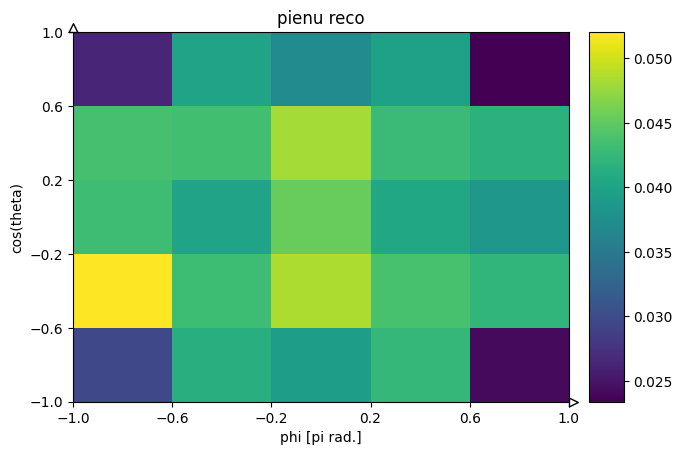

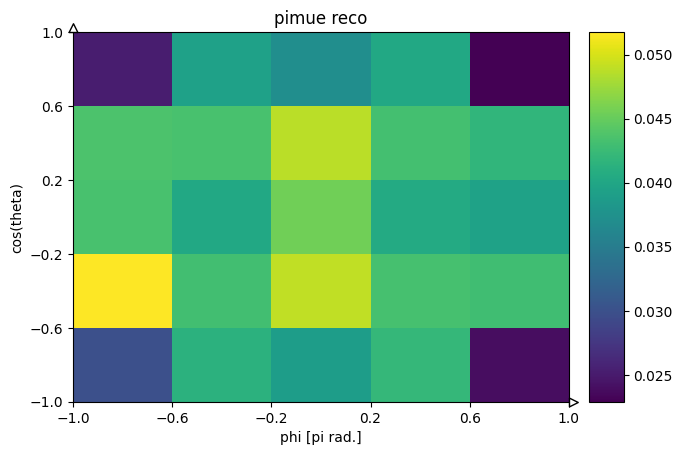

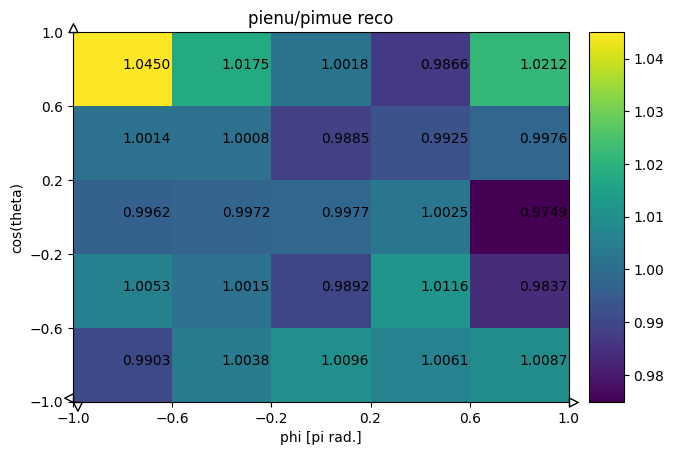

In [406]:
plot2d(hists2dnorm)

In [407]:
def plot1ds(hists, xlabel, labels, norm):
    """
    hists: unnormalized histograms
    norm: normalization factor
    """
    print(labels)
    hnorms = {}
    yerrs = {}
    for k in ["pienu", "pimue"]:
        hnorms[k] = []
        yerrs[k] = []
        for i in range(len(hists[k])):
            hnorms[k].append(hists[k][i]/norm[k])
            yerrs[k].append( np.sqrt(hists[k][i].view())/norm[k] )

    figs = []
    axs = []
    for i in range(3):
        fig, ax = plt.subplots()
        figs.append(fig)
        axs.append(ax)
    for i, k in enumerate(["pienu", "pimue"]):
        print(labels[k])
        #for j in range(len(hnorms[k])):
        hep.histplot(hnorms[k], yerr=yerrs[k], label=labels[k], ax=axs[i])
    hratios = []
    ratioerrs = []
    for j in range(len(hnorms["pienu"])):
        hratio = hnorms["pienu"][j]/hnorms["pimue"][j]
        hratios.append(hratio)
        yerr = hratio.view()*np.sqrt(yerrs["pienu"][j]**2/hnorms["pienu"][j].view()**2+ yerrs["pimue"][j]**2/hnorms["pimue"][j].view()**2)
        ratioerrs.append(yerr)
    hep.histplot(hratios, yerr=ratioerrs, label=labels["pienu"],
                     ax=axs[2])
    for i in range(3):
        axs[i].set_xlabel(xlabel)
        axs[i].legend()

    min0 = 0.9 * np.min([np.min(h.view()) for h in hnorms["pienu"]])
    max0 = 1.05 * np.max([np.max(h.view()) for h in hnorms["pienu"]])
    min1 = 0.9 * np.min([np.min(h.view()) for h in hnorms["pimue"]])
    max1 = 1.05 * np.max([np.max(h.view()) for h in hnorms["pimue"]])
    axs[0].set_ylim(min0, max0)
    axs[1].set_ylim(min1, max1)

    min2 = 0.9 * np.min([np.min(h.view()) for h in hratios])
    max2 = 1.05 * np.max([np.max(h.view()) for h in hratios])

    axs[2].set_ylim(min2, 1.05*np.max(hratios[0].view()))

    axs[0].set_title("pienu {}".format(cond))
    axs[1].set_title("pimue {}".format(cond))
    axs[2].set_title("pienu / pimue {}".format(cond))

{'pienu': ['phi / pi -1.00 to -0.60', 'phi / pi -0.60 to -0.20', 'phi / pi -0.20 to 0.20', 'phi / pi 0.20 to 0.60', 'phi / pi 0.60 to 1.00'], 'pimue': ['phi / pi -1.00 to -0.60', 'phi / pi -0.60 to -0.20', 'phi / pi -0.20 to 0.20', 'phi / pi 0.20 to 0.60', 'phi / pi 0.60 to 1.00']}
['phi / pi -1.00 to -0.60', 'phi / pi -0.60 to -0.20', 'phi / pi -0.20 to 0.20', 'phi / pi 0.20 to 0.60', 'phi / pi 0.60 to 1.00']
['phi / pi -1.00 to -0.60', 'phi / pi -0.60 to -0.20', 'phi / pi -0.20 to 0.20', 'phi / pi 0.20 to 0.60', 'phi / pi 0.60 to 1.00']
{'pienu': ['cosTheta -1.00 to -0.60', 'cosTheta -0.60 to -0.20', 'cosTheta -0.20 to 0.20', 'cosTheta 0.20 to 0.60', 'cosTheta 0.60 to 1.00'], 'pimue': ['cosTheta -1.00 to -0.60', 'cosTheta -0.60 to -0.20', 'cosTheta -0.20 to 0.20', 'cosTheta 0.20 to 0.60', 'cosTheta 0.60 to 1.00']}
['cosTheta -1.00 to -0.60', 'cosTheta -0.60 to -0.20', 'cosTheta -0.20 to 0.20', 'cosTheta 0.20 to 0.60', 'cosTheta 0.60 to 1.00']
['cosTheta -1.00 to -0.60', 'cosTheta -0.

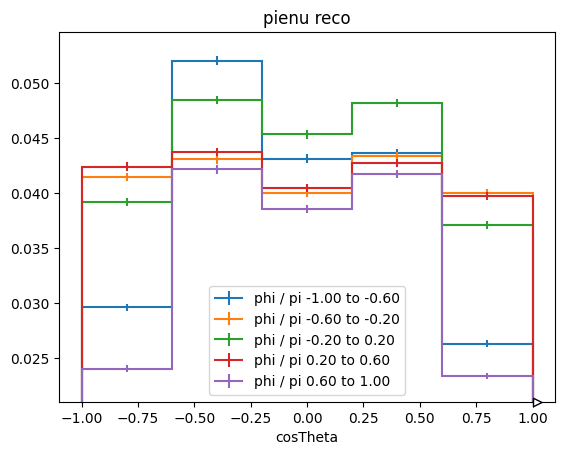

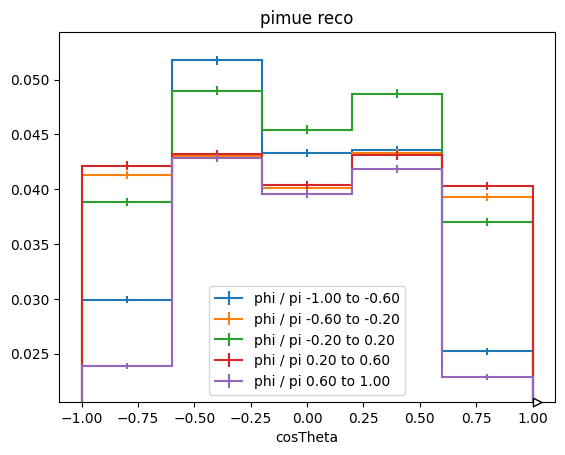

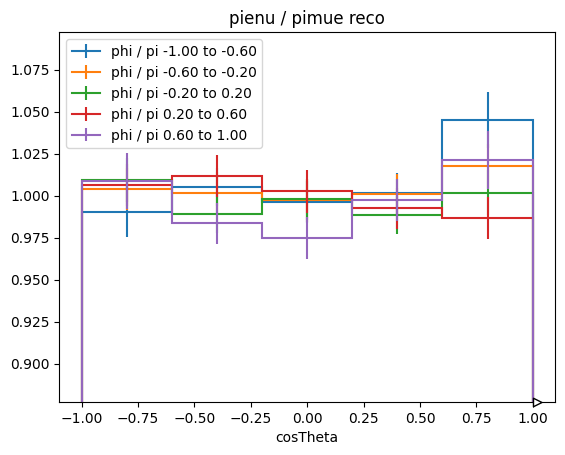

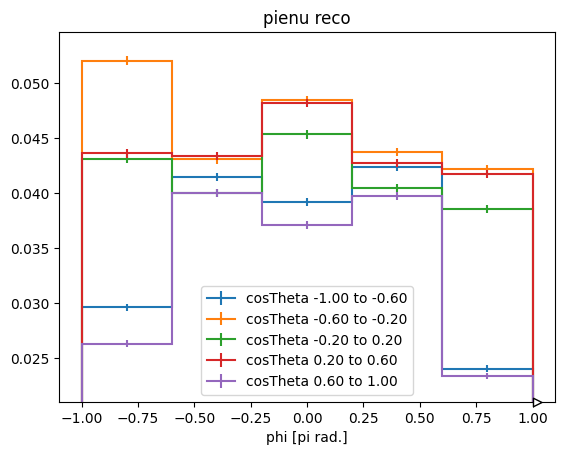

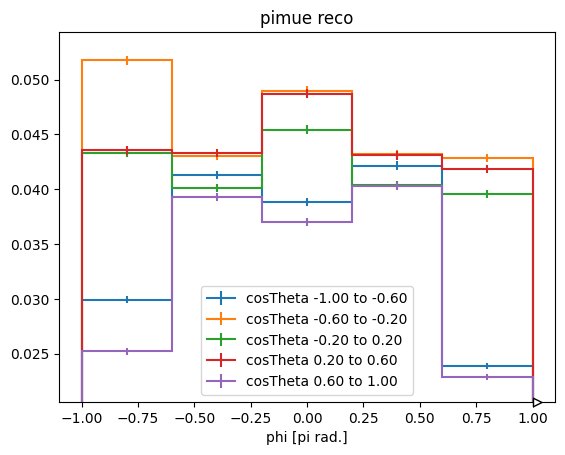

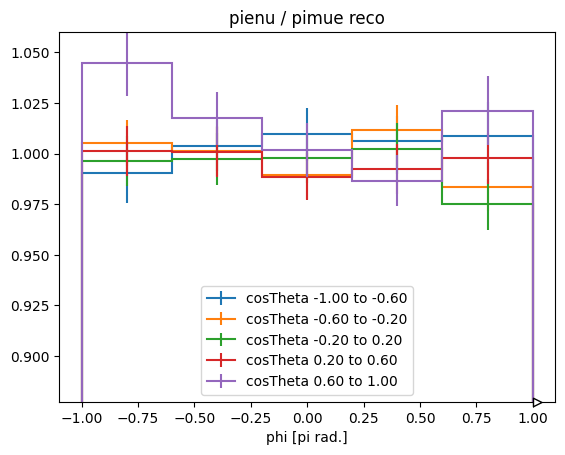

In [408]:
labels = {}
nbins = {"phi" : nphinorm, "costheta" : ncostheta}
norm = {"pienu" : hists2d["pienu"].sum(), "pimue" : hists2d["pimue"].sum()}
for vk, vv in nbins.items():
    labels[vk] = {}
    for k in ["pienu", "pimue"]:
        s = "phi / pi" if vk == "costheta" else "cosTheta"
        labels[vk][k] = ["{} {:.2f} to {:.2f}".format(s,
            hists2d[k].axes[0].edges[i], hists2d[k].axes[0].edges[i+1]) for i in range(vv)]

plot1ds(hists_costheta, "cosTheta", labels["costheta"], norm)
plot1ds(hists_phi, "phi [pi rad.]", labels["phi"], norm)


In [409]:
print(1/np.sqrt(hists2d["pienu"].sum()/25))
1/np.sqrt(hists2d["pienu"].view())

0.009052402319856717


array([[0.01052049, 0.00793726, 0.0087171 , 0.00866914, 0.01115596],
       [0.00888722, 0.00872406, 0.0090469 , 0.00869598, 0.00905098],
       [0.00914434, 0.00822356, 0.00850241, 0.00824814, 0.00939931],
       [0.00879021, 0.00865939, 0.00899733, 0.0087551 , 0.0090849 ],
       [0.01167059, 0.00881819, 0.009221  , 0.00886241, 0.01183784]])

{'pienu': array([0.00081054, 0.00087304, 0.00083492, 0.00087067, 0.00078209]), 'pimue': array([0.00081087, 0.00087577, 0.00083987, 0.00087431, 0.00077978])}
[0.00575478 0.00530655 0.0055103  0.00530713 0.00601442]


Text(0.5, 0, 'costheta')

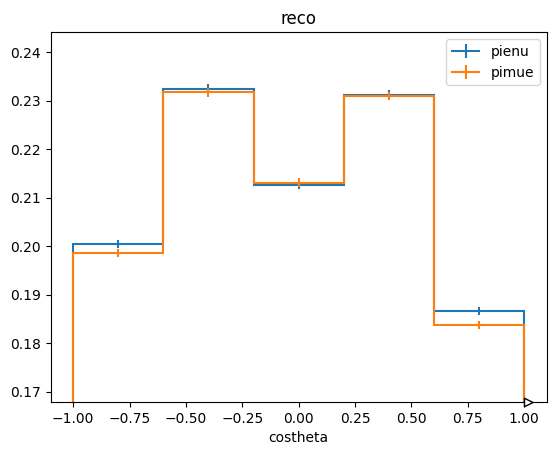

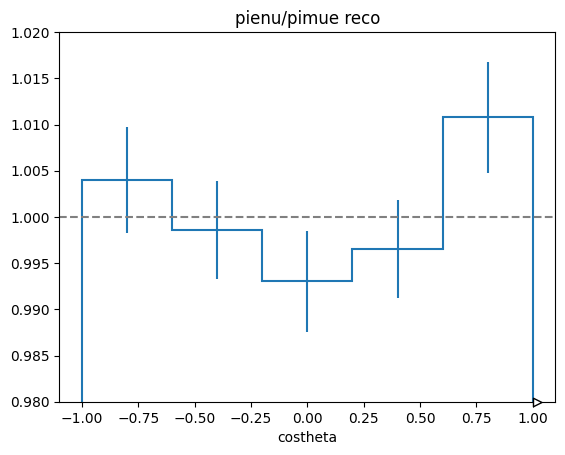

In [410]:
h_costheta = {
    "pienu" : hists2d["pienu"][::sum, :],
    "pimue" : hists2d["pimue"][::sum, :]
}

yerrs = {
    "pienu" : np.sqrt(h_costheta["pienu"].view())/hists2d["pienu"].sum(),
    "pimue" : np.sqrt(h_costheta["pimue"].view())/hists2d["pimue"].sum()
}

print(yerrs)

fig, ax = plt.subplots()
hep.histplot([h_costheta["pienu"]/hists2d["pienu"].sum(),
              h_costheta["pimue"]/hists2d["pienu"].sum()],
              yerr=[yerrs['pienu'], yerrs['pimue']], label=["pienu", "pimue"],
              ax=ax)
ymin = 0.9 * np.min(np.array([h_costheta["pienu"].view(), h_costheta["pienu"].view()])) / hists2d["pienu"].sum()
ymax = 1.05 * np.max(np.array([h_costheta["pienu"].view(), h_costheta["pienu"].view()])) / hists2d["pienu"].sum()
ax.set_ylim(ymin, ymax)
ax.legend()
ax.set_title("{}".format(cond))
ax.set_xlabel("costheta")

fig, ax = plt.subplots()
h_costheta_ratio = h_costheta["pienu"]/h_costheta["pimue"] * hists2d["pimue"].sum()/hists2d["pienu"].sum()
ratioerrs = h_costheta_ratio.view() * np.sqrt(1/h_costheta["pienu"].view() + 1/h_costheta["pimue"].view())
print(ratioerrs)
hep.histplot(h_costheta_ratio, yerr=ratioerrs, ax=ax)
ax.set_ylim(0.98, 1.02)
ax.axhline(1, color='grey', linestyle='--')
ax.set_title("pienu/pimue {}".format(cond))
ax.set_xlabel("costheta")